In [467]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from lightgbm import LGBMRegressor
from random import randint, uniform
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
import scipy.stats.distributions as dists
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *
import matplotlib.pyplot as plt


## New way to test cv

In [246]:
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
            print(f"validation_split_date:{ validation_split_date}")
        print(f"Max date: {data[date_column].max()} ; Min date: {data[date_column].min()} ; len:{len(data)}")
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')
        print(f"TRAIN: {start_train, end_train}")
        print(f"TEST: {start_test, end_test}")

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
                  "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits 


# Import dataset for train and validate the algorithm

In [232]:
ds_1 = pd.read_csv('../data_test/daily-minimum-temperatures-in-me.csv')
ds_1['Date'] = pd.to_datetime(ds_1.Date)
ds_2 = pd.read_csv('../data_test/Electric_Production.csv')
ds_2.rename(columns={'DATE':'Date'},inplace=True)
ds_2['Date'] = pd.to_datetime(ds_2.Date)
ds_3 = pd.read_csv('../data_test/monthly-beer-production-in-austr.csv')

In [233]:
df = ds_1.merge(ds_2,on='Date',how='inner')
df.rename(columns={'Date':'record_date','IPG2211A2N':'production','Daily minimum temperatures':'temperature'},inplace=True)
data_for_modeling = df.copy()

In [255]:
tscv = TimeBasedCV(train_period=12,
                   test_period=8,
                   freq='months')

In [259]:
for train_index, test_index in tscv.split(data_for_modeling,
                   validation_split_date=None, date_column='record_date'):
    print('*****')
    print(train_index, test_index)
    print('*****')
# get number of splits
tscv.get_n_splits()

validation_split_date:1986-01-01
Max date: 1990-12-01 00:00:00 ; Min date: 1985-01-01 00:00:00 ; len:72
TRAIN: (datetime.date(1985, 1, 1), datetime.date(1986, 1, 1))
TEST: (datetime.date(1986, 1, 1), datetime.date(1986, 9, 1))
Train period: 1985-01-01 - 1986-01-01 , Test period 1986-01-01 - 1986-09-01 # train records 12 , # test records 8
Train period: 1985-09-01 - 1986-09-01 , Test period 1986-09-01 - 1987-05-01 # train records 12 , # test records 8
Train period: 1986-05-01 - 1987-05-01 , Test period 1987-05-01 - 1988-01-01 # train records 12 , # test records 8
Train period: 1987-01-01 - 1988-01-01 , Test period 1988-01-01 - 1988-09-01 # train records 12 , # test records 8
Train period: 1987-09-01 - 1988-09-01 , Test period 1988-09-01 - 1989-05-01 # train records 12 , # test records 8
Train period: 1988-05-01 - 1989-05-01 , Test period 1989-05-01 - 1990-01-01 # train records 12 , # test records 8
Train period: 1989-01-01 - 1990-01-01 , Test period 1990-01-01 - 1990-09-01 # train recor

7

In [261]:
columns = 'temperature'
label = 'production'
X = data_for_modeling[['record_date',columns]]
X.iloc[:,X.columns!='record_date'] = X.iloc[:,X.columns!='record_date'].astype(float)
y = data_for_modeling[label]

In [422]:
from sklearn.linear_model import LinearRegression
import numpy as np

scores = []
for train_index, test_index in tscv.split(X, validation_split_date=None):

    data_train   = X.loc[train_index].drop('record_date', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('record_date', axis=1)
    target_test  = y.loc[test_index]

    # if needed, do preprocessing here

    clf = LinearRegression()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)

    # accuracy for the current fold only    
    r2score = clf.score(data_test,target_test)

    scores.append(r2score)

# this is the average accuracy over all folds
average_r2score = np.mean(scores)
print(average_r2score)
#### End of example ####

validation_split_date:1986-01-01
Max date: 1990-12-01 00:00:00 ; Min date: 1985-01-01 00:00:00 ; len:72
TRAIN: (datetime.date(1985, 1, 1), datetime.date(1986, 1, 1))
TEST: (datetime.date(1986, 1, 1), datetime.date(1986, 9, 1))
Train period: 1985-01-01 - 1986-01-01 , Test period 1986-01-01 - 1986-09-01 # train records 12 , # test records 8
Train period: 1985-09-01 - 1986-09-01 , Test period 1986-09-01 - 1987-05-01 # train records 12 , # test records 8
Train period: 1986-05-01 - 1987-05-01 , Test period 1987-05-01 - 1988-01-01 # train records 12 , # test records 8
Train period: 1987-01-01 - 1988-01-01 , Test period 1988-01-01 - 1988-09-01 # train records 12 , # test records 8
Train period: 1987-09-01 - 1988-09-01 , Test period 1988-09-01 - 1989-05-01 # train records 12 , # test records 8
Train period: 1988-05-01 - 1989-05-01 , Test period 1989-05-01 - 1990-01-01 # train records 12 , # test records 8
Train period: 1989-01-01 - 1990-01-01 , Test period 1990-01-01 - 1990-09-01 # train recor

In [459]:
#### Example- RandomizedSearchCV ####
tscv = TimeBasedCV(train_period=12,
                   test_period=8,
                   freq='months')
index_output = tscv.split(data_for_modeling, validation_split_date=None)

lgbm = SGDRegressor()

lgbmPd = {"alpha": dists.uniform(0.0001, 0.1),
          "l1_ratio": dists.uniform(0.5, 0.95),
          "penalty": ["l2", "l1", "elasticnet"],
          "max_iter": dists.randint(100, 2000, 50)
         }

validation_split_date:1986-01-01
Max date: 1990-12-01 00:00:00 ; Min date: 1985-01-01 00:00:00 ; len:72
TRAIN: (datetime.date(1985, 1, 1), datetime.date(1986, 1, 1))
TEST: (datetime.date(1986, 1, 1), datetime.date(1986, 9, 1))
Train period: 1985-01-01 - 1986-01-01 , Test period 1986-01-01 - 1986-09-01 # train records 12 , # test records 8
Train period: 1985-09-01 - 1986-09-01 , Test period 1986-09-01 - 1987-05-01 # train records 12 , # test records 8
Train period: 1986-05-01 - 1987-05-01 , Test period 1987-05-01 - 1988-01-01 # train records 12 , # test records 8
Train period: 1987-01-01 - 1988-01-01 , Test period 1988-01-01 - 1988-09-01 # train records 12 , # test records 8
Train period: 1987-09-01 - 1988-09-01 , Test period 1988-09-01 - 1989-05-01 # train records 12 , # test records 8
Train period: 1988-05-01 - 1989-05-01 , Test period 1989-05-01 - 1990-01-01 # train records 12 , # test records 8
Train period: 1989-01-01 - 1990-01-01 , Test period 1990-01-01 - 1990-09-01 # train recor

In [460]:
model = RandomizedSearchCV(
    estimator = lgbm,
    param_distributions = lgbmPd,
    n_iter = 1000,
    n_jobs = -1,
    cv = index_output,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    pre_dispatch='2*n_jobs',
    random_state = None,
    return_train_score = True)

In [461]:
model.fit(X.drop('record_date', axis=1).values,y.values)
#### End of example ####

Fitting 7 folds for each of 1000 candidates, totalling 7000 fits
[CV] END alpha=0.09959387279515293, l1_ratio=0.7724187956849831, max_iter=1097, penalty=l1; total time=   0.0s
[CV] END alpha=0.09959387279515293, l1_ratio=0.7724187956849831, max_iter=1097, penalty=l1; total time=   0.0s
[CV] END alpha=0.09959387279515293, l1_ratio=0.7724187956849831, max_iter=1097, penalty=l1; total time=   0.0s
[CV] END alpha=0.09959387279515293, l1_ratio=0.7724187956849831, max_iter=1097, penalty=l1; total time=   0.0s
[CV] END alpha=0.09959387279515293, l1_ratio=0.7724187956849831, max_iter=1097, penalty=l1; total time=   0.0s
[CV] END alpha=0.09959387279515293, l1_ratio=0.7724187956849831, max_iter=1097, penalty=l1; total time=   0.0s
[CV] END alpha=0.09959387279515293, l1_ratio=0.7724187956849831, max_iter=1097, penalty=l1; total time=   0.0s
[CV] END alpha=0.05985578403343244, l1_ratio=0.7135408519134374, max_iter=768, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.05985578403343244, l1_r

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-package

=elasticnet; total time=   0.0s
[CV] END alpha=0.055659546723842504, l1_ratio=1.4485253773076905, max_iter=562, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.055659546723842504, l1_ratio=1.4485253773076905, max_iter=562, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.07722954714350189, l1_ratio=0.5820729789650884, max_iter=1676, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.06430603566554076, l1_ratio=0.833399682805908, max_iter=364, penalty=l1; total time=   0.0s
[CV] END alpha=0.05551774328514459, l1_ratio=1.1233332442498667, max_iter=1718, penalty=l1; total time=   0.0s
[CV] END alpha=0.0060528387325660135, l1_ratio=0.9461365954440966, max_iter=939, penalty=l2; total time=   0.0s
[CV] END alpha=0.0060528387325660135, l1_ratio=0.9461365954440966, max_iter=939, penalty=l2; total time=   0.0s
[CV] END alpha=0.05551774328514459, l1_ratio=1.1233332442498667, max_iter=1718, penalty=l1; total time=   0.0s
[CV] END alpha=0.06430603566554076, l1_ratio=0.833399682

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-package

33, penalty=l2; total time=   0.0s
[CV] END alpha=0.023239123809620676, l1_ratio=0.6715010707820583, max_iter=1376, penalty=l1; total time=   0.0s
[CV] END alpha=0.040984238068918426, l1_ratio=0.518622030587618, max_iter=924, penalty=l1; total time=   0.0s
[CV] END alpha=0.09372220183046649, l1_ratio=1.4179417625990975, max_iter=1833, penalty=l2; total time=   0.0s
[CV] END alpha=0.09372220183046649, l1_ratio=1.4179417625990975, max_iter=1833, penalty=l2; total time=   0.0s
[CV] END alpha=0.0418114971419598, l1_ratio=0.5321441653964205, max_iter=1317, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.07193081432921447, l1_ratio=0.8024262909246209, max_iter=1257, penalty=l2; total time=   0.0s
[CV] END alpha=0.09372220183046649, l1_ratio=1.4179417625990975, max_iter=1833, penalty=l2; total time=   0.0s
[CV] END alpha=0.023239123809620676, l1_ratio=0.6715010707820583, max_iter=1376, penalty=l1; total time=   0.0s
[CV] END alpha=0.09372220183046649, l1_ratio=1.4179417625990975, max_

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-package

[CV] END alpha=0.06612259280054637, l1_ratio=1.3152927554600764, max_iter=1780, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.003674667045051505, l1_ratio=0.6009397189360851, max_iter=1272, penalty=l2; total time=   0.0s
[CV] END alpha=0.06612259280054637, l1_ratio=1.3152927554600764, max_iter=1780, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.08602667233941794, l1_ratio=0.5318396351383422, max_iter=468, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.0680336012285283, l1_ratio=0.6988747537603313, max_iter=1926, penalty=l1; total time=   0.0s[CV] END alpha=0.06612259280054637, l1_ratio=1.3152927554600764, max_iter=1780, penalty=elasticnet; total time=   0.0s

[CV] END alpha=0.06612259280054637, l1_ratio=1.3152927554600764, max_iter=1780, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.02068752336669194, l1_ratio=0.9438448320583931, max_iter=845, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.09928068050425637, l1_ratio=1.2841354834827272, m

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-package


[CV] END alpha=0.045265962479435276, l1_ratio=1.119966567248967, max_iter=1671, penalty=l2; total time=   0.0s
[CV] END alpha=0.02390750515840484, l1_ratio=1.4420286515004053, max_iter=478, penalty=l1; total time=   0.0s
[CV] END alpha=0.045265962479435276, l1_ratio=1.119966567248967, max_iter=1671, penalty=l2; total time=   0.0s
[CV] END alpha=0.006411845292828611, l1_ratio=0.8928389911903178, max_iter=714, penalty=l2; total time=   0.0s
[CV] END alpha=0.02390750515840484, l1_ratio=1.4420286515004053, max_iter=478, penalty=l1; total time=   0.0s
[CV] END alpha=0.066550252305922, l1_ratio=0.8050722465559959, max_iter=1926, penalty=l2; total time=   0.0s
[CV] END alpha=0.013815859917801643, l1_ratio=0.9174387021707955, max_iter=1261, penalty=l2; total time=   0.0s
[CV] END alpha=0.02390750515840484, l1_ratio=1.4420286515004053, max_iter=478, penalty=l1; total time=   0.0s
[CV] END alpha=0.045265962479435276, l1_ratio=1.119966567248967, max_iter=1671, penalty=l2; total time=   0.0s
[CV]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-package

ter=1341, penalty=l1; total time=   0.0s
[CV] END alpha=0.07269768534637884, l1_ratio=0.6836064480129436, max_iter=1282, penalty=l2; total time=   0.0s
[CV] END alpha=0.04460180530263857, l1_ratio=0.58046512408464, max_iter=1341, penalty=l1; total time=   0.0s
[CV] END alpha=0.07269768534637884, l1_ratio=0.6836064480129436, max_iter=1282, penalty=l2; total time=   0.0s
[CV] END alpha=0.04460180530263857, l1_ratio=0.58046512408464, max_iter=1341, penalty=l1; total time=   0.0s
[CV] END alpha=0.06091305527337501, l1_ratio=1.0057091732059624, max_iter=1685, penalty=l2; total time=   0.0s
[CV] END alpha=0.06091305527337501, l1_ratio=1.0057091732059624, max_iter=1685, penalty=l2; total time=   0.0s
[CV] END alpha=0.06091305527337501, l1_ratio=1.0057091732059624, max_iter=1685, penalty=l2; total time=   0.0s
[CV] END alpha=0.03934618385011813, l1_ratio=0.8606025946120031, max_iter=336, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.06091305527337501, l1_ratio=1.0057091732059624, max

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-package


[CV] END alpha=0.03323475145351443, l1_ratio=1.2152350216075387, max_iter=675, penalty=l2; total time=   0.0s
[CV] END alpha=0.04954105197656859, l1_ratio=1.175345871285783, max_iter=261, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.031263693592583824, l1_ratio=1.2923207513951223, max_iter=759, penalty=l2; total time=   0.0s
[CV] END alpha=0.01976685700294344, l1_ratio=1.338613541436132, max_iter=1582, penalty=l1; total time=   0.0s
[CV] END alpha=0.03323475145351443, l1_ratio=1.2152350216075387, max_iter=675, penalty=l2; total time=   0.0s
[CV] END alpha=0.031263693592583824, l1_ratio=1.2923207513951223, max_iter=759, penalty=l2; total time=   0.0s
[CV] END alpha=0.04954105197656859, l1_ratio=1.175345871285783, max_iter=261, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.01976685700294344, l1_ratio=1.338613541436132, max_iter=1582, penalty=l1; total time=   0.0s
[CV] END alpha=0.08663384129807937, l1_ratio=0.98923519804398, max_iter=1597, penalty=l1; total time=  

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-package


[CV] END alpha=0.003647542887016841, l1_ratio=0.6383418878866504, max_iter=1744, penalty=l2; total time=   0.0s
[CV] END alpha=0.009289156769791905, l1_ratio=1.1615896340222878, max_iter=1811, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.02862038157973732, l1_ratio=0.7679477567252907, max_iter=278, penalty=l2; total time=   0.0s
[CV] END alpha=0.03944518192677016, l1_ratio=0.8335542043566923, max_iter=666, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.009289156769791905, l1_ratio=1.1615896340222878, max_iter=1811, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.009289156769791905, l1_ratio=1.1615896340222878, max_iter=1811, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.04858417006435096, l1_ratio=1.2602357587256425, max_iter=1886, penalty=l1; total time=   0.0s
[CV] END alpha=0.003647542887016841, l1_ratio=0.6383418878866504, max_iter=1744, penalty=l2; total time=   0.0s
[CV] END alpha=0.009289156769791905, l1_ratio=1.1615896340222878, max_iter=1

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-package

[CV] END alpha=0.07111728597312135, l1_ratio=0.8622473223444267, max_iter=329, penalty=l2; total time=   0.0s
[CV] END alpha=0.07111728597312135, l1_ratio=0.8622473223444267, max_iter=329, penalty=l2; total time=   0.0s
[CV] END alpha=0.07111728597312135, l1_ratio=0.8622473223444267, max_iter=329, penalty=l2; total time=   0.0s
[CV] END alpha=0.07111728597312135, l1_ratio=0.8622473223444267, max_iter=329, penalty=l2; total time=   0.0s
[CV] END alpha=0.07111728597312135, l1_ratio=0.8622473223444267, max_iter=329, penalty=l2; total time=   0.0s
[CV] END alpha=0.07111728597312135, l1_ratio=0.8622473223444267, max_iter=329, penalty=l2; total time=   0.0s
[CV] END alpha=0.036982239293469436, l1_ratio=1.2981954921335563, max_iter=1428, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.036982239293469436, l1_ratio=1.2981954921335563, max_iter=1428, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.036982239293469436, l1_ratio=1.2981954921335563, max_iter=1428, penalty=elasticnet;

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-package

[CV] END alpha=0.005152183835034918, l1_ratio=1.1304898194824908, max_iter=494, penalty=l2; total time=   0.0s
[CV] END alpha=0.021229714926565137, l1_ratio=1.2805645127339356, max_iter=1567, penalty=l1; total time=   0.0s
[CV] END alpha=0.039683858491312236, l1_ratio=0.9296164207990685, max_iter=1322, penalty=l1; total time=   0.0s
[CV] END alpha=0.052335189476385054, l1_ratio=1.2702254387273155, max_iter=193, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.07516650294419852, l1_ratio=0.8417344981849566, max_iter=839, penalty=l2; total time=   0.0s
[CV] END alpha=0.027159228002682147, l1_ratio=0.694329354647516, max_iter=646, penalty=l2; total time=   0.0s
[CV] END alpha=0.052335189476385054, l1_ratio=1.2702254387273155, max_iter=193, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.052335189476385054, l1_ratio=1.2702254387273155, max_iter=193, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.0356227347774541, l1_ratio=1.254245718665479, max_iter=1703, penalty=l1

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-package

[CV] END alpha=0.02992303504839261, l1_ratio=0.7741369513345477, max_iter=1486, penalty=l1; total time=   0.0s

[CV] END alpha=0.0009292692909468658, l1_ratio=1.1325378162281645, max_iter=1294, penalty=l1; total time=   0.0s
[CV] END alpha=0.0009292692909468658, l1_ratio=1.1325378162281645, max_iter=1294, penalty=l1; total time=   0.0s
[CV] END alpha=0.02070325239764789, l1_ratio=1.0485563067121908, max_iter=1195, penalty=l2; total time=   0.0s
[CV] END alpha=0.010458191256238902, l1_ratio=0.9727723109080078, max_iter=642, penalty=l1; total time=   0.0s
[CV] END alpha=0.0009292692909468658, l1_ratio=1.1325378162281645, max_iter=1294, penalty=l1; total time=   0.0s
[CV] END alpha=0.03332553031188791, l1_ratio=0.7149083113538823, max_iter=1972, penalty=l2; total time=   0.0s
[CV] END alpha=0.02992303504839261, l1_ratio=0.7741369513345477, max_iter=1486, penalty=l1; total time=   0.0s
[CV] END alpha=0.017950635637470413, l1_ratio=0.8147965506978181, max_iter=1608, penalty=l2; total time= 

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/user/.local/lib/python3.8/site-package

[CV] END alpha=0.07940701101494496, l1_ratio=0.647658896110719, max_iter=1460, penalty=l2; total time=   0.0s[CV] END alpha=0.08504272388644908, l1_ratio=0.8577272117215418, max_iter=1041, penalty=l2; total time=   0.0s
[CV] END alpha=0.02604786712533772, l1_ratio=0.6109061192845044, max_iter=1657, penalty=l1; total time=   0.0s
[CV] END alpha=0.04400388679913354, l1_ratio=1.3613562518648599, max_iter=191, penalty=l2; total time=   0.0s
[CV] END alpha=0.08504272388644908, l1_ratio=0.8577272117215418, max_iter=1041, penalty=l2; total time=   0.0s
[CV] END alpha=0.0694513447371371, l1_ratio=0.9744993605408733, max_iter=1912, penalty=l1; total time=   0.0s
[CV] END alpha=0.08504272388644908, l1_ratio=0.8577272117215418, max_iter=1041, penalty=l2; total time=   0.0s
[CV] END alpha=0.08798851203130817, l1_ratio=0.5159291742805935, max_iter=1803, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.0694513447371371, l1_ratio=0.9744993605408733, max_iter=1912, penalty=l1; total time=   0.0

RandomizedSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                        [12, 13, 14, 15, 16, 17, 18, 19]),
                       ([8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
                        [20, 21, 22, 23, 24, 25, 26, 27]),
                       ([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
                        [28, 29, 30, 31, 32, 33, 34, 35]),
                       ([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
                        [36, 37, 38, 39, 40, 41, 42, 43]),
                       ([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
                        [44, 45, 46, 47, 48, 49, 50, 51]),
                       ([40, 41, 4...
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd05b3b8a30>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd05b3daac0>,
                                        'max_iter': <scipy.stats

In [462]:
all_results = model.cv_results_
best_reg = model.best_estimator_

In [476]:
model.best_score_

-15.662496221421803

In [466]:
best_reg

SGDRegressor(alpha=0.07801021724500645, l1_ratio=0.710287041052685,
             max_iter=2027, penalty='l1')

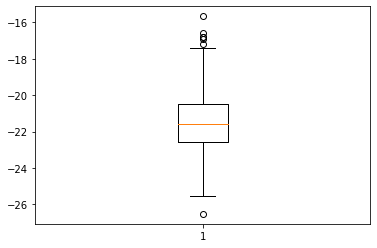

In [474]:
test_score = pd.Series(all_results['mean_test_score'])
test_score = test_score[~test_score.isna()]

plt.boxplot(test_score)
plt.show()
